In [333]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import pairwise_distances_argmin_min

In [159]:
FOLDER_PATH = "D:\\Google Drive\\Catherning Folder\\THU\\Thesis\\Recipe datasets\\scirep-cuisines-detail"
FILES = ["allr_recipes.txt","epic_recipes.txt","menu_recipes.txt"]

In [237]:
recipes = []
for file in FILES:
    with open(os.path.join(FOLDER_PATH,file)) as f:
        for i,recipe in enumerate(f):
            data = recipe.strip('\n').split('\t')
            recipes.append({"cuisine":data[0],"id":i,"ingredients":data[1:]})
        
df_train = pd.DataFrame(recipes)

,cuisine,id,ingredients
0,Canada,0,"[egg, yeast, wheat, milk, lard]"
1,Canada,1,"[pork, carrot, pea, onion, potato]"
2,Canada,2,[maple_syrup]
3,Canada,3,"[wheat, yeast, almond, honey, oat, date, veget..."
4,Canada,4,"[butter, lovage, clam, wheat, onion, thyme, po..."
...,...,...,...
57686,italian,2453,"[kiwi, olive_oil, clam, white_wine, orange, sa..."
57687,italian,2454,"[tomato, butter, beef, onion, red_wine, black_..."
57688,italian,2455,"[vegetable, wheat, egg, cheese, olive_oil]"
57689,italian,2456,"[tomato, clam, black_pepper, parsley, celery, ..."


### Data cleaning

In [429]:
# Fusion of the same cuisines
df_train=df_train.replace("Mexico","Mexican")
df_train=df_train.replace("mexico","Mexican")
df_train=df_train.replace("chinese","Chinese")
df_train=df_train.replace("China","Chinese")
df_train=df_train.replace("France","French")
df_train=df_train.replace("japanese","Japanese")
df_train=df_train.replace("Japan","Japanese")
df_train=df_train.replace("Thailand","Thai")
df_train=df_train.replace("German","Germany")
df_train=df_train.replace("India","Indian")
df_train=df_train.replace("Israel","Jewish")
df_train=df_train.replace("italian","Italian")
df_train=df_train.replace("Italy","Italian")
df_train=df_train.replace("Scandinavia","Scandinavian")
df_train=df_train.replace("Vietnam","Vietnamese")
df_train=df_train.replace("Korea","Korean")
df_train=df_train.replace("korean","Korean")
df_train=df_train.replace("EasternEuropean_Russian","Eastern_Europe")
df_train=df_train.replace('Spain','Spanish_Portuguese')
df_train

,cuisine,id,ingredients,all_ingredients,american_id
0,Canada,0,"[egg, yeast, wheat, milk, lard]",egg;yeast;wheat;milk;lard,NaN
1,Canada,1,"[pork, carrot, pea, onion, potato]",pork;carrot;pea;onion;potato,NaN
2,Canada,2,[maple_syrup],maple_syrup,NaN
3,Canada,3,"[wheat, yeast, almond, honey, oat, date, veget...",wheat;yeast;almond;honey;oat;date;vegetable_oi...,NaN
4,Canada,4,"[butter, lovage, clam, wheat, onion, thyme, po...",butter;lovage;clam;wheat;onion;thyme;potato;ye...,NaN
...,...,...,...,...,...
57686,Italian,2453,"[kiwi, olive_oil, clam, white_wine, orange, sa...",kiwi;olive_oil;clam;white_wine;orange;salmon;f...,NaN
57687,Italian,2454,"[tomato, butter, beef, onion, red_wine, black_...",tomato;butter;beef;onion;red_wine;black_pepper...,NaN
57688,Italian,2455,"[vegetable, wheat, egg, cheese, olive_oil]",vegetable;wheat;egg;cheese;olive_oil,NaN
57689,Italian,2456,"[tomato, clam, black_pepper, parsley, celery, ...",tomato;clam;black_pepper;parsley;celery;macaroni,NaN


# Data analysis

American        40150
Mexico           1754
Italian          1715
Italy            1461
Asian            1176
                ...  
Indonesia          12
East-African       11
Belgium            11
Israel              9
Bangladesh          4
Name: cuisine, Length: 69, dtype: int64

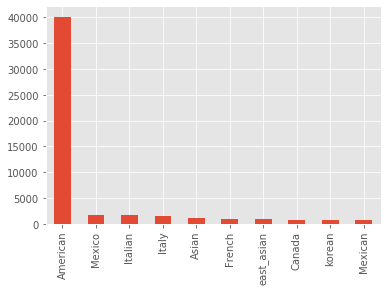

In [238]:
%matplotlib inline

plt.style.use('ggplot')
df_train['cuisine'].value_counts().head(10).plot(kind='bar')

df_train['cuisine'].value_counts()

Results are worse when we remove American recipes!
Check what exactly are those results
See if we should remove american, if yes, how to improve score ???

### Counter for ingredients

In [242]:
counters = {}
for cuisine in df_train['cuisine'].unique():
    counters[cuisine] = Counter()
    indices = (df_train['cuisine'] == cuisine)
    for ingredients in df_train[indices]['ingredients']:
        counters[cuisine].update(ingredients)

In [243]:
counters['French'].most_common(10)

[('butter', 633),
 ('egg', 558),
 ('wheat', 472),
 ('olive_oil', 353),
 ('cream', 347),
 ('garlic', 335),
 ('onion', 323),
 ('milk', 260),
 ('black_pepper', 259),
 ('parsley', 237)]

In [244]:
top10 = pd.DataFrame([[items[0] for items in counters[cuisine].most_common(10)] for cuisine in counters],
            index=[cuisine for cuisine in counters],
            columns=['top{}'.format(i) for i in range(1, 11)])
top10

,top1,top2,top3,top4,top5,top6,top7,top8,top9,top10
Canada,wheat,butter,egg,onion,garlic,milk,black_pepper,cane_molasses,vegetable_oil,pepper
Turkey,garlic,onion,tomato,butter,wheat,yogurt,olive_oil,bell_pepper,pepper,egg
Caribbean,onion,garlic,vegetable_oil,black_pepper,tomato,olive_oil,pepper,cayenne,bell_pepper,chicken
Bangladesh,onion,cayenne,vegetable_oil,turmeric,garlic,cilantro,coriander,beef,potato,cardamom
Indian,cumin,turmeric,onion,coriander,cayenne,garlic,ginger,vegetable_oil,pepper,fenugreek
French,butter,egg,wheat,olive_oil,cream,garlic,onion,milk,black_pepper,parsley
Italian,olive_oil,garlic,tomato,onion,basil,parmesan_cheese,macaroni,egg,butter,black_pepper
Jewish,egg,wheat,butter,onion,vegetable_oil,olive_oil,black_pepper,cinnamon,garlic,lemon_juice
Korean,garlic,scallion,cayenne,soy_sauce,sesame_oil,black_pepper,rice,soybean,roasted_sesame_seed,vegetable
Iran,onion,tomato,yogurt,black_pepper,garlic,cardamom,olive_oil,walnut,vegetable_oil,dill


In [245]:
df_train['all_ingredients'] = df_train['ingredients'].map(";".join)
df_train.head()

,cuisine,id,ingredients,all_ingredients
0,Canada,0,"[egg, yeast, wheat, milk, lard]",egg;yeast;wheat;milk;lard
1,Canada,1,"[pork, carrot, pea, onion, potato]",pork;carrot;pea;onion;potato
2,Canada,2,[maple_syrup],maple_syrup
3,Canada,3,"[wheat, yeast, almond, honey, oat, date, veget...",wheat;yeast;almond;honey;oat;date;vegetable_oi...
4,Canada,4,"[butter, lovage, clam, wheat, onion, thyme, po...",butter;lovage;clam;wheat;onion;thyme;potato;ye...


In [246]:
df_train['all_ingredients'].str.contains('garlic').value_counts()

False    40226
True     17465
Name: all_ingredients, dtype: int64

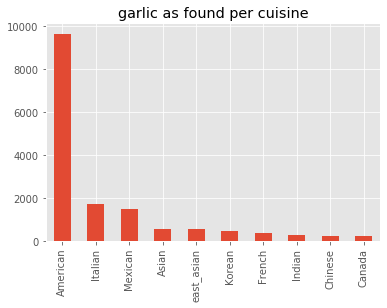

In [247]:
indices = df_train['all_ingredients'].str.contains('garlic')
df_train[indices]['cuisine'].value_counts().head(10).plot(kind='bar',
                                                 title='garlic as found per cuisine')

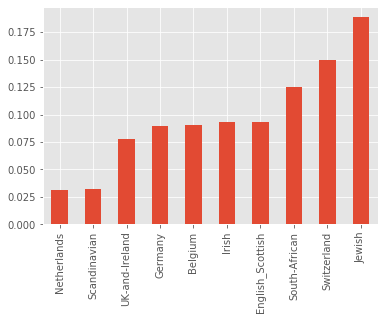

In [248]:
relative_freq = (df_train[indices]['cuisine'].value_counts() / df_train['cuisine'].value_counts())
relative_freq.sort_values(inplace=True)
relative_freq.head(10).plot(kind='bar')

In [249]:
unique = np.unique(top10.values.ravel())
unique.shape

(73,)

In [250]:
# spot ingredients which have a high degree of uniqueness

# fig, axes = plt.subplots(8, 8, figsize=(20, 20))
# for ingredient, ax_index in zip(unique, range(64)):
#     indices = df_train['all_ingredients'].str.contains(ingredient)
#     relative_freq = (df_train[indices]['cuisine'].value_counts() / df_train['cuisine'].value_counts())
#     relative_freq.head(10).plot(kind='bar', ax=axes.ravel()[ax_index], fontsize=7, title=ingredient)

In [251]:
# np.array(['all-purpose flour', 'avocado', 'baking powder', 'baking soda',
#        'black pepper', 'butter', 'buttermilk', 'cachaca',
#        'cajun seasoning', 'carrots', 'cayenne pepper', 'chili powder',
#        'coconut milk', 'corn starch', 'corn tortillas', 'cumin seed',
#        'dried oregano', 'dried thyme', 'eggs', 'extra-virgin olive oil',
#        'feta cheese crumbles', 'fish sauce', 'fresh lemon juice',
#        'fresh lime juice', 'garam masala', 'garlic', 'garlic cloves',
#        'ginger', 'grated parmesan cheese', 'green bell pepper',
#        'green onions', 'ground allspice', 'ground black pepper',
#        'ground cinnamon', 'ground cumin', 'ground ginger',
#        'ground turmeric', 'jalapeno chilies', 'large eggs', 'lime', 'milk',
#        'mirin', 'oil', 'olive oil', 'onions', 'paprika', 'pepper',
#        'potatoes', 'red bell pepper', 'rice vinegar', 'sake', 'salt',
#        'scallions', 'sesame oil', 'sesame seeds', 'shallots', 'sour cream',
#        'soy sauce', 'sugar', 'tomatoes', 'unsalted butter',
#        'vegetable oil', 'water']).shape

### More data cleaning by cuisine and prepare for classification

In [ ]:
# # remove most americans for now, to have better distribution of cuisines
# print(len(df_train))
# american_df = df_train[df_train["cuisine"]=="American"].sample(frac=0.9)
# print(len(american_df))
# df_train=df_train[~df_train.isin(american_df).all(1)]
# print(len(df_train))

# df_train = df_train[(df_train["cuisine"]!="American")]

In [354]:
cv = CountVectorizer()

X = cv.fit_transform(df_train['all_ingredients'].values)
X
# 57691 recipes, 383 ingredients

<57691x383 sparse matrix of type '<class 'numpy.int64'>'
	with 476250 stored elements in Compressed Sparse Row format>

### PCA

In [355]:
x_american=cv.fit_transform(df_train[df_train["cuisine"]=="American"]['all_ingredients'].values)
x_american

<40150x354 sparse matrix of type '<class 'numpy.int64'>'
	with 318499 stored elements in Compressed Sparse Row format>

In [417]:
am_id=0
for i in range(len(df_train)):
    if df_train.loc[i,"cuisine"]=="American":
        df_train.loc[i,"american_id"]=am_id
        am_id+=1

KeyboardInterrupt: 

In [418]:
df_train.american_id.isnan()

AttributeError: 'Series' object has no attribute 'isnan'

In [330]:
K_clusters=100

reduced_data = TruncatedSVD(n_components=2).fit_transform(x_american)
kmeans = MiniBatchKMeans(n_clusters=K_clusters, n_init=10)
kmeans.fit(reduced_data)
kmeans.labels_

array([93, 11, 92, ..., 46, 13, 38])

In [421]:
df_train[df_train["cuisine"]=="American"]

,cuisine,id,ingredients,all_ingredients,american_id
4437,American,4437,"[tomato, honey, chicken, mustard, onion]",tomato;honey;chicken;mustard;onion,0.0
4438,American,4438,"[feta_cheese, black_pepper, ginger, pecan, chi...",feta_cheese;black_pepper;ginger;pecan;chicken;...,1.0
4439,American,4439,"[cocoa, milk]",cocoa;milk,2.0
4440,American,4440,"[tomato, olive_oil, parmesan_cheese, macaroni,...",tomato;olive_oil;parmesan_cheese;macaroni;basi...,3.0
4441,American,4441,"[olive_oil, pepper, onion, thyme, potato, whit...",olive_oil;pepper;onion;thyme;potato;white_wine...,4.0
...,...,...,...,...,...
49622,American,7797,"[tomato, vinegar, okra, onion, lima_bean, corn...",tomato;vinegar;okra;onion;lima_bean;corn;cayen...,40145.0
49623,American,7798,"[orange, olive_oil, pork, garlic, oregano]",orange;olive_oil;pork;garlic;oregano,40146.0
49624,American,7799,"[butter, cane_molasses, wheat, vanilla, walnut...",butter;cane_molasses;wheat;vanilla;walnut;coco...,40147.0
49625,American,7800,"[butter, cane_molasses, wheat, blueberry, milk...",butter;cane_molasses;wheat;blueberry;milk_fat;...,40148.0


In [361]:
closest,_ = pairwise_distances_argmin_min(kmeans.cluster_centers_, reduced_data)
if np.unique(closest).shape[0]!=K_clusters:
    print(np.unique(closest).shape)
    print("https://stackoverflow.com/questions/21660937/get-nearest-point-to-centroid-scikit-learn")

array(['honey', 'banana', 'almond', 'blueberry', 'yogurt', 'kiwi'],
      dtype='<U23')

In [432]:
df_train[(df_train["american_id"].isin(closest)) ^ (df_train["american_id"].isnull())]

,cuisine,id,ingredients,all_ingredients,american_id
0,Canada,0,"[egg, yeast, wheat, milk, lard]",egg;yeast;wheat;milk;lard,NaN
1,Canada,1,"[pork, carrot, pea, onion, potato]",pork;carrot;pea;onion;potato,NaN
2,Canada,2,[maple_syrup],maple_syrup,NaN
3,Canada,3,"[wheat, yeast, almond, honey, oat, date, veget...",wheat;yeast;almond;honey;oat;date;vegetable_oi...,NaN
4,Canada,4,"[butter, lovage, clam, wheat, onion, thyme, po...",butter;lovage;clam;wheat;onion;thyme;potato;ye...,NaN
...,...,...,...,...,...
57686,Italian,2453,"[kiwi, olive_oil, clam, white_wine, orange, sa...",kiwi;olive_oil;clam;white_wine;orange;salmon;f...,NaN
57687,Italian,2454,"[tomato, butter, beef, onion, red_wine, black_...",tomato;butter;beef;onion;red_wine;black_pepper...,NaN
57688,Italian,2455,"[vegetable, wheat, egg, cheese, olive_oil]",vegetable;wheat;egg;cheese;olive_oil,NaN
57689,Italian,2456,"[tomato, clam, black_pepper, parsley, celery, ...",tomato;clam;black_pepper;parsley;celery;macaroni,NaN


In [390]:

for recipe in df_train[df_train["cuisine"]=="American"]["ingredients"]:
    sorted_array=np.sort(np.array(recipe))
    print(type(recipe))
    print(recipe.index.tolist())
np.sort(cv.inverse_transform(x_american[closest]))

AxisError: axis -1 is out of bounds for array of dimension 0

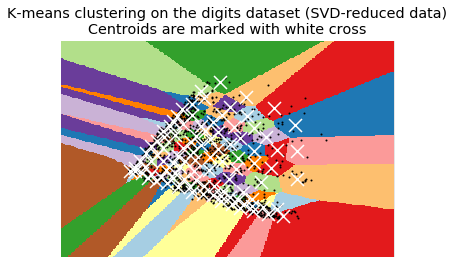

In [332]:
reduced_data = reduced_data[:2000]

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)

# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the digits dataset (SVD-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

In [318]:
print(list(cv.vocabulary_.keys())[:100])

['tomato', 'honey', 'chicken', 'mustard', 'onion', 'feta_cheese', 'black_pepper', 'ginger', 'pecan', 'raspberry', 'cayenne', 'cocoa', 'milk', 'olive_oil', 'parmesan_cheese', 'macaroni', 'basil', 'garlic', 'pepper', 'thyme', 'potato', 'white_wine', 'chickpea', 'carrot', 'beet', 'butter', 'wheat', 'vanilla', 'cream_cheese', 'egg', 'cream', 'cane_molasses', 'oat', 'nutmeg', 'banana', 'vinegar', 'mushroom', 'nut', 'cider', 'grapefruit', 'sesame_seed', 'vegetable_oil', 'brussels_sprout', 'bacon', 'oregano', 'lard', 'lemon_juice', 'orange_juice', 'gelatin', 'apricot', 'roasted_peanut', 'coconut', 'starch', 'almond', 'orange', 'raisin', 'cinnamon', 'pistachio', 'lemon', 'lime', 'walnut', 'buttermilk', 'cherry', 'date', 'pineapple', 'fruit', 'currant', 'zucchini', 'cottage_cheese', 'popcorn', 'cheddar_cheese', 'apple', 'cereal', 'whole_grain_wheat_flour', 'tarragon', 'cheese', 'ham', 'scallion', 'beef_broth', 'leek', 'marjoram', 'chicken_broth', 'sage', 'celery', 'white_bread', 'rosemary', 'sh

In [319]:
enc = LabelEncoder()
y = enc.fit_transform(df_train.cuisine)
print(enc.classes_)
enc.classes_.shape

['African' 'American' 'Asian' 'Austria' 'Bangladesh' 'Belgium'
 'Cajun_Creole' 'Canada' 'Caribbean' 'Central_SouthAmerican' 'Chinese'
 'East-African' 'Eastern-Europe' 'Eastern_Europe' 'English_Scottish'
 'French' 'Germany' 'Greek' 'Indian' 'Indonesia' 'Iran' 'Irish' 'Italian'
 'Japanese' 'Jewish' 'Korean' 'Lebanon' 'Malaysia' 'Mediterranean'
 'Mexican' 'MiddleEastern' 'Moroccan' 'Netherlands' 'North-African'
 'Pakistan' 'Philippines' 'Portugal' 'Scandinavian' 'South-African'
 'South-America' 'Southern_SoulFood' 'Southwestern' 'Spanish_Portuguese'
 'Switzerland' 'Thai' 'Turkey' 'UK-and-Ireland' 'Vietnamese'
 'West-African' 'asian' 'east_asian' 'western']


(52,)

In [256]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
unique, counts = np.unique(y_test, return_counts=True)
dict(zip(unique, counts))

{0: 20,
 1: 8002,
 2: 244,
 3: 5,
 5: 4,
 6: 26,
 7: 135,
 8: 39,
 9: 51,
 10: 88,
 12: 53,
 13: 38,
 14: 40,
 15: 259,
 16: 57,
 17: 32,
 18: 131,
 19: 4,
 20: 3,
 21: 13,
 22: 646,
 23: 58,
 24: 79,
 25: 175,
 26: 5,
 27: 2,
 28: 53,
 29: 477,
 30: 49,
 31: 32,
 32: 7,
 33: 14,
 34: 6,
 35: 8,
 36: 9,
 37: 52,
 38: 7,
 39: 19,
 40: 66,
 41: 25,
 42: 74,
 43: 3,
 44: 65,
 45: 7,
 46: 60,
 47: 26,
 48: 3,
 49: 5,
 50: 181,
 51: 82}

# Logistic Regression

In [264]:
logistic = LogisticRegression(class_weight="balanced")
logistic.fit(X_train, y_train)

D:\Applications\Anaconda3\envs\pandas_analysis\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Applications\Anaconda3\envs\pandas_analysis\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [265]:
logistic.score(X_test, y_test)

0.48938382875465813

## Results

D:\Applications\Anaconda3\envs\pandas_analysis\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


Text(0.5, 14.017307692307668, 'Predicted label')

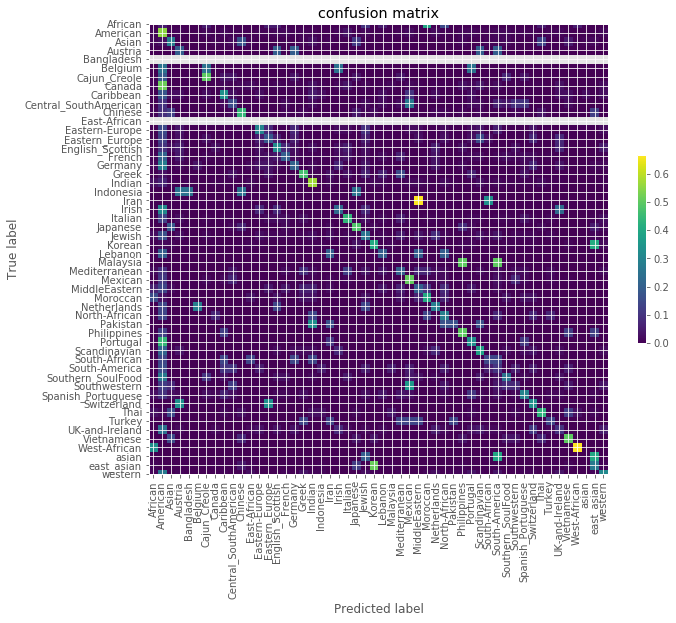

In [266]:
plt.figure(figsize=(10, 10))

cm = confusion_matrix(y_test, logistic.predict(X_test))
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.imshow(cm_normalized, interpolation='nearest')
plt.title("confusion matrix")
plt.colorbar(shrink=0.3)
cuisines = df_train['cuisine'].value_counts().index
tick_marks = np.arange(len(cuisines))
plt.xticks(tick_marks, enc.classes_, rotation=90)
plt.yticks(tick_marks, enc.classes_)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [267]:
y_pred = logistic.predict(X_test)

print(classification_report(y_test, y_pred, labels=[i for i in range(69)], target_names=enc.classes_))

                       precision    recall  f1-score   support

              African       0.00      0.00      0.00        20
             American       0.91      0.55      0.69      8002
                Asian       0.39      0.28      0.33       244
              Austria       0.01      0.20      0.02         5
           Bangladesh       0.00      0.00      0.00         0
              Belgium       0.00      0.00      0.00         4
         Cajun_Creole       0.08      0.50      0.14        26
               Canada       0.02      0.01      0.01       135
            Caribbean       0.08      0.33      0.13        39
Central_SouthAmerican       0.07      0.16      0.09        51
              Chinese       0.23      0.44      0.31        88
         East-African       0.00      0.00      0.00         0
       Eastern-Europe       0.13      0.30      0.18        53
       Eastern_Europe       0.06      0.18      0.10        38
     English_Scottish       0.08      0.33      0.12  

# Random Forest

much slower and a bit worse

In [261]:
# Random Forest PCA

rf = RandomForestClassifier(n_estimators=460, random_state=123)
rf.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
rf.score(X_test, y_test)

## Results

In [ ]:
y_pred = rf.predict(X_test)

print(classification_report(y_test, y_pred, labels=[i for i in range(69)], target_names=cuisines))